## Claustrophobic Streets
Work by Matt Franchi


### Notebook Description: 
In this notebook, we construct an aggregated map of 'clutter' in New York City, defined as various types of street furniture that were encountered on walks around various neighborhoods. A limitation of this notebook is that we are unable to capture certain types of clutter with data, ie. streetside dining. Furthermore, some data lacks precision at the 50-foot granularity with which we segmentize sidewalks (ie., sidewalk scaffolding). Nonetheless, we hope this notebook accurately captures the density of street clutter density across the entirety of New York City. All datasets used come from NYC OpenData. 

### Performance Notes: 
We run this notebook on a compute node with 64GB RAM and 8 CPUs. 




### Module Imports 

In [1]:
import pandas as pd 
import geopandas as gpd 
import osmnx as ox 
from shapely import wkt 

import matplotlib.pyplot as plt 

from tqdm import tqdm 
from glob import glob 


import logging 
# add logger name, time and date to logger messages
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger("street-clutter")



logger.info("Initialization complete.")

2024-07-21 15:30:56,914 - street-clutter - INFO - Initialization complete.


In [2]:
# the projected CRS to convert coordinates into much more accurate positioning data, using the Long Island State Plane
PROJ_CRS = 'EPSG:2263'

# the maximum distance to search for a nearby street segment. Since we segmentize by 50 feet, we can search within 25 feet
MAX_DISTANCE=25

CUTOFF= pd.to_datetime("2023-12-02")


### Loading Segmentized NYC Sidewalk Graph 

In [3]:
# load nyc sidewalk graph 
nyc_sidewalks = pd.read_csv("../data/segmentized_nyc_sidewalks.csv", engine='pyarrow')

# set first column to be named 'point index' 
nyc_sidewalks.columns = ['point_index'] + list(nyc_sidewalks.columns[1:])

In [4]:
# Add a column for sidewalk width 
nyc_sidewalks.shape_area = nyc_sidewalks.shape_area.astype(float)
nyc_sidewalks.shape_leng = nyc_sidewalks.shape_leng.astype(float)
nyc_sidewalks['shape_width'] = nyc_sidewalks.shape_area / nyc_sidewalks.shape_leng
nyc_sidewalks['shape_width'].describe() 

count    2.532597e+06
mean     5.358406e+00
std      1.455869e+00
min      5.797213e-01
25%      4.451437e+00
50%      5.138477e+00
75%      6.161151e+00
max      4.021492e+01
Name: shape_width, dtype: float64

In [5]:
nyc_sidewalks = gpd.GeoDataFrame(nyc_sidewalks, geometry=nyc_sidewalks['geometry'].apply(wkt.loads), crs='EPSG:2263')

In [6]:
# we buffer each point by 25 feet, creating a 50-diameter circle centered at the point. This captures nearby clutter. 
nyc_sidewalks['geometry'] = nyc_sidewalks['geometry'].buffer(MAX_DISTANCE)

### Sidewalk Scaffolding 

In [7]:
# read DoB active scaffolding permits 
scaffolding_permits = pd.read_csv("../data/dob_active_sheds.csv", engine='pyarrow')
scaffolding_permits = gpd.GeoDataFrame(scaffolding_permits, geometry=gpd.points_from_xy(scaffolding_permits['Longitude Point'], scaffolding_permits['Latitude Point']), crs='EPSG:4326')
scaffolding_permits = scaffolding_permits.to_crs(PROJ_CRS)

In [8]:
scaffolding_permits['First Permit Date']  = pd.to_datetime(scaffolding_permits['First Permit Date'])

scaffolding_permits = scaffolding_permits[scaffolding_permits['First Permit Date'] <= CUTOFF]
scaffolding_permits['First Permit Date'].describe()


count                             7771
mean     2022-07-19 11:03:34.489769728
min                2006-04-27 00:00:00
25%                2022-02-10 00:00:00
50%                2023-02-08 00:00:00
75%                2023-07-17 00:00:00
max                2023-12-01 00:00:00
Name: First Permit Date, dtype: object

### Bus Stop Shelters

In [9]:
# read bus stop shelters 
bus_stop_shelters = gpd.read_file("../data/Bus Stop Shelters.geojson").to_crs(PROJ_CRS)
bus_stop_shelters['latitude'] = bus_stop_shelters['latitude'].astype(float)
bus_stop_shelters['longitude'] = bus_stop_shelters['longitude'].astype(float)

# Bus stop installation date is not present, so filtering is out-of-scope

### Trash Cans / Waste Baskets 

In [10]:
# load trash cans 
trash_cans = gpd.read_file("../data/DSNY Litter Basket Inventory_20240525.geojson").to_crs(PROJ_CRS)
trash_cans['longitude'] = trash_cans.geometry.centroid.to_crs('EPSG:4326').x
trash_cans['latitude'] = trash_cans.geometry.centroid.to_crs('EPSG:4326').y

# trash can installation date is not present, so filtering is out-of-scope

### LinkNYC Kiosks

In [11]:
# load linknyc
linknyc = gpd.read_file("../data/LinkNYC_Kiosk_Locations_20240525.csv")
linknyc = gpd.GeoDataFrame(linknyc, geometry=gpd.points_from_xy(linknyc['Longitude'], linknyc['Latitude']), crs='EPSG:4326').to_crs(PROJ_CRS)

linknyc['Installation Complete'] = pd.to_datetime(linknyc['Installation Complete'])
linknyc = linknyc[linknyc['Installation Complete'] <= CUTOFF]
linknyc['Installation Complete'].describe()


count                             2135
mean     2017-12-16 23:36:23.606557440
min                1971-12-01 00:00:00
25%                2016-11-12 00:00:00
50%                2017-07-18 00:00:00
75%                2018-02-17 00:00:00
max                2023-11-30 00:00:00
Name: Installation Complete, dtype: object

### Bicycle Parking Shelters 

In [12]:
# load bicycle parking shelters 
bicycle_parking_shelters = gpd.read_file("../data/Bicycle Parking Shelters.geojson").to_crs(PROJ_CRS)
bicycle_parking_shelters['build_date'] = pd.to_datetime(bicycle_parking_shelters['build_date'])
bicycle_parking_shelters = bicycle_parking_shelters[bicycle_parking_shelters['build_date'] <= CUTOFF]
bicycle_parking_shelters['build_date'].describe()


count                               17
mean     2008-07-26 18:21:10.588235264
min                2007-12-17 00:00:00
25%                2008-07-01 00:00:00
50%                2008-09-12 00:00:00
75%                2008-10-13 00:00:00
max                2008-12-17 00:00:00
Name: build_date, dtype: object

### Bicycle Racks

In [13]:
# load bicycle racks 
bicycle_racks = gpd.read_file("../data/Bicycle Parking.geojson").to_crs(PROJ_CRS)
bicycle_racks['date_inst'] = pd.to_datetime(bicycle_racks['date_inst'])
bicycle_racks = bicycle_racks[bicycle_racks['date_inst'] <= CUTOFF]
bicycle_racks['date_inst'].describe()



count                            31585
mean     2011-06-02 09:53:44.100047616
min                1900-01-01 00:00:00
25%                2010-06-14 00:00:00
50%                2013-05-31 00:00:00
75%                2017-03-02 00:00:00
max                2023-05-02 00:00:00
Name: date_inst, dtype: object

### CityBench

In [14]:
# load citybench
citybench = pd.read_csv("../data/City_Bench_Locations__Historical__20240525.csv")
citybench = gpd.GeoDataFrame(citybench, geometry=gpd.points_from_xy(citybench['Longitude'], citybench['Latitude']), crs='EPSG:4326').to_crs(PROJ_CRS)
citybench['Installati'] = pd.to_datetime(citybench['Installati'])
citybench = citybench[citybench['Installati'] <= CUTOFF]
citybench['Installati'].describe()


count                             2141
mean     2015-04-09 03:36:34.301728256
min                2012-04-01 00:00:00
25%                2013-07-10 00:00:00
50%                2014-11-18 00:00:00
75%                2017-02-04 00:00:00
max                2019-09-30 00:00:00
Name: Installati, dtype: object

### Street Trees 

In [15]:
# load trees 
trees = pd.read_csv("../data/Forestry_Tree_Points.csv", engine='pyarrow')
trees = gpd.GeoDataFrame(trees, geometry=wkt.loads(trees['Geometry']), crs='EPSG:4326').to_crs(PROJ_CRS)
trees['CreatedDate'] = pd.to_datetime(trees['CreatedDate'])
trees = trees[trees['CreatedDate'] <= CUTOFF]
trees['CreatedDate'].describe()



count                          1030313
mean     2017-02-22 19:52:37.527894016
min                2015-02-28 05:00:00
25%                2016-01-05 17:34:38
50%                2016-06-21 16:30:22
75%                2017-10-05 00:00:00
max                2023-12-01 21:43:00
Name: CreatedDate, dtype: object

### News Stands

In [16]:
# load newsstands 
newsstands = pd.read_csv("../data/NewsStands.csv", engine='pyarrow')
newsstands = gpd.GeoDataFrame(newsstands, geometry=wkt.loads(newsstands['the_geom']), crs='EPSG:4326').to_crs(PROJ_CRS)
newsstands['Built_Date'] = pd.to_datetime(newsstands['Built_Date'])
newsstands = newsstands[newsstands['Built_Date'] <= CUTOFF]
newsstands['Built_Date'].describe() 

count                              357
mean     2011-09-04 23:31:45.882352896
min                2007-09-03 00:00:00
25%                2008-07-30 00:00:00
50%                2010-11-08 00:00:00
75%                2013-06-04 00:00:00
max                2021-12-22 00:00:00
Name: Built_Date, dtype: object

### Parking Meters

In [17]:
# load parking meters 
parking_meters = pd.read_csv("../data/Parking_Meters_Locations_and_Status_20240604.csv")
parking_meters = gpd.GeoDataFrame(parking_meters, geometry=wkt.loads(parking_meters['Location']), crs='EPSG:4326').to_crs(PROJ_CRS)

# parking meter installation date is not present, so filtering is out-of-scope

### Fire Hydrants

In [18]:
# load hydrants 
hydrants = gpd.read_file("../data/NYCDEP Citywide Hydrants.geojson").to_crs(PROJ_CRS) 

# hydrant installation date is not present, so filtering is out-of-scope


### Street Signs 

In [19]:
# load street signs 
street_signs = pd.read_csv("../data/Street_Sign_Work_Orders_20240721.csv", engine='pyarrow')

# only keep 'Current' record type 
street_signs = street_signs[street_signs['record_type'] == 'Current']
street_signs['order_completed_on_date'] = pd.to_datetime(street_signs['order_completed_on_date'])
street_signs = street_signs[street_signs['order_completed_on_date'] <= CUTOFF]
street_signs = gpd.GeoDataFrame(street_signs, geometry=gpd.points_from_xy(street_signs['sign_x_coord'], street_signs['sign_y_coord']), crs='EPSG:2263')
street_signs['order_completed_on_date'].describe()

count                          1114356
mean     2018-10-03 12:00:38.921851904
min                1953-08-07 00:00:00
25%                2017-08-28 00:00:00
50%                2020-01-17 00:00:00
75%                2021-07-19 00:00:00
max                2023-12-02 00:00:00
Name: order_completed_on_date, dtype: object

### Bollards 

In [20]:
# load bollards 
bollards = pd.read_csv("../data/Traffic_Bollards_Tracking_and_Installations_20240721.csv", engine='pyarrow')
bollards['Date'] = pd.to_datetime(bollards['Date'])
bollards = bollards[bollards['Date'] <= CUTOFF]
bollards['Date'].describe()

# we choose not to process bollards, as locations need to be geocoded. Latitude/Longitude is not present in the dataset.

count                            54665
mean     2016-05-17 19:10:59.939632384
min                2005-01-10 00:00:00
25%                2012-09-10 00:00:00
50%                2017-07-12 00:00:00
75%                2020-06-25 00:00:00
max                2023-08-31 00:00:00
Name: Date, dtype: object

### Subset of Street Poles that are Leased by Telecommunications Companies

In [21]:
# load mobile telecommunications-leased street poles dataset 
mobile_telecom_poles = pd.read_csv("../data/Mobile_Telecommunications_Franchise_Pole_Reservation_Locations_20240721.csv", engine='pyarrow')
mobile_telecom_poles['Installation Date'] = pd.to_datetime(mobile_telecom_poles['Installation Date'])
mobile_telecom_poles = mobile_telecom_poles[mobile_telecom_poles['Installation Date'] <= CUTOFF]

mobile_telecom_poles = gpd.GeoDataFrame(mobile_telecom_poles, geometry=gpd.points_from_xy(mobile_telecom_poles['Longitude'], mobile_telecom_poles['Latitude']), crs='EPSG:4326').to_crs(PROJ_CRS)

mobile_telecom_poles['Installation Date'].describe()

# plottable, but unsure how many poles are leased, compared to total distribution of poles. With this uncertainty, we choose not to process this dataset.


count                             6293
mean     2017-03-13 06:42:02.803114752
min                2008-06-17 00:00:00
25%                2015-07-24 00:00:00
50%                2019-01-16 00:00:00
75%                2020-04-09 00:00:00
max                2023-12-01 00:00:00
Name: Installation Date, dtype: object

### Spatial Joining of Clutters to Sidewalk Graph 

In [22]:
# sjoin nearest bus stops and trash cans to sidewalk
len_before = len(nyc_sidewalks)
bus_stop_shelters = gpd.sjoin(nyc_sidewalks, bus_stop_shelters, )
logger.info(f"Missing {len(bus_stop_shelters[bus_stop_shelters['index_right'].isna()])} bus stop shelters.")

2024-07-21 15:32:01,570 - street-clutter - INFO - Missing 0 bus stop shelters.


In [23]:
# sjoin nearest trash cans to sidewalk
len_before = len(trash_cans)
trash_cans = gpd.sjoin(nyc_sidewalks, trash_cans, )
logger.info(f"Removed {len_before - len(trash_cans)} trash cans that are not on sidewalks.")

2024-07-21 15:32:01,988 - street-clutter - INFO - Removed 1644 trash cans that are not on sidewalks.


In [24]:
# sjoin nearest linknyc to sidewalk
len_before = len(linknyc)
linknyc = gpd.sjoin(nyc_sidewalks, linknyc, )
logger.info(f"LinkNYC: {len_before} -> {len(linknyc)}")

2024-07-21 15:32:02,259 - street-clutter - INFO - LinkNYC: 2135 -> 4436


In [25]:
# sjoin nearest citybench 
len_before = len(citybench)
citybench = gpd.sjoin(nyc_sidewalks, citybench, )
logger.info(f"Citybench: {len_before} -> {len(citybench)}")

2024-07-21 15:32:02,537 - street-clutter - INFO - Citybench: 2141 -> 1259


In [26]:
# sjoint nearest bicycle parking shelters to sidewalk
len_before = len(bicycle_parking_shelters)
bicycle_parking_shelters = gpd.sjoin(nyc_sidewalks, bicycle_parking_shelters, )
logger.info(f"Bicycle Parking Shelters: {len_before} -> {len(bicycle_parking_shelters)}")

2024-07-21 15:32:02,730 - street-clutter - INFO - Bicycle Parking Shelters: 17 -> 35


In [27]:
# sjoin nearest bicycle racks to sidewalk
len_before = len(bicycle_racks)
bicycle_racks = gpd.sjoin(nyc_sidewalks, bicycle_racks, )
logger.info(f"Bicycle Racks: {len_before} -> {len(bicycle_racks)}")

2024-07-21 15:32:03,284 - street-clutter - INFO - Bicycle Racks: 31585 -> 57587


In [28]:
# sjoin nearest trees to sidewalk
len_before = len(trees)
trees = gpd.sjoin(nyc_sidewalks, trees, )
logger.info(f"Trees: {len_before} -> {len(trees)}")


2024-07-21 15:32:07,723 - street-clutter - INFO - Trees: 1030313 -> 1824560


In [29]:
# sjoin nearest newsstands to sidewalk
len_before = len(newsstands)
newsstands = gpd.sjoin(nyc_sidewalks, newsstands, )
logger.info(f"Newsstands: {len_before} -> {len(newsstands)}")


2024-07-21 15:32:07,949 - street-clutter - INFO - Newsstands: 357 -> 531


In [30]:
BUFFER=100 
# buffer scaffolding_permits points, then sjoin to sidewalks
scaffolding_permits.geometry = scaffolding_permits.geometry.buffer(BUFFER)
scaffolding_permits = gpd.sjoin(nyc_sidewalks, scaffolding_permits, op='intersects')

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [31]:
# sjoin nearest parking meters to sidewalk
len_before = len(parking_meters)
parking_meters = gpd.sjoin(nyc_sidewalks, parking_meters, )
logger.info(f"Parking Meters: {len_before} -> {len(parking_meters)}")


2024-07-21 15:32:09,141 - street-clutter - INFO - Parking Meters: 13336 -> 25942


In [32]:
# sjoin nearest hydrants to sidewalk
len_before = len(hydrants)
hydrants = gpd.sjoin(nyc_sidewalks, hydrants, )
logger.info(f"Hydrants: {len_before} -> {len(hydrants)}")

2024-07-21 15:32:10,045 - street-clutter - INFO - Hydrants: 109410 -> 215202


In [33]:
# sjoin nearest street signs to sidewalk
len_before = len(street_signs)
street_signs = gpd.sjoin(nyc_sidewalks, street_signs, )
logger.info(f"Street Signs: {len_before} -> {len(street_signs)}")


2024-07-21 15:32:13,490 - street-clutter - INFO - Street Signs: 1114356 -> 863911


### Aggregating Counts by Point on Sidewalk Graph 

In [34]:
# now, get number of bus stops, trash cans, linknyc, citybench, bicycle parking shelters, and bicycle racks per sidewalk
bus_stop_counts = bus_stop_shelters.groupby('point_index').size().reset_index(name='bus_stop_count').fillna(0)
trash_can_counts = trash_cans.groupby('point_index').size().reset_index(name='trash_can_count').fillna(0)
linknyc_counts = linknyc.groupby('point_index').size().reset_index(name='linknyc_count').fillna(0)
citybench_counts = citybench.groupby('point_index').size().reset_index(name='citybench_count').fillna(0)
bicycle_parking_shelter_counts = bicycle_parking_shelters.groupby('point_index').size().reset_index(name='bicycle_parking_shelter_count').fillna(0)
bicycle_rack_counts = bicycle_racks.groupby('point_index').size().reset_index(name='bicycle_rack_count').fillna(0)
tree_counts = trees.groupby('point_index').size().reset_index(name='tree_count').fillna(0)
newsstand_counts = newsstands.groupby('point_index').size().reset_index(name='newsstand_count').fillna(0)
parking_meter_counts = parking_meters.groupby('point_index').size().reset_index(name='parking_meter_count').fillna(0)
hydrant_counts = hydrants.groupby('point_index').size().reset_index(name='hydrant_count').fillna(0)
street_sign_counts = street_signs.groupby('point_index').size().reset_index(name='street_sign_count').fillna(0)


In [35]:
# merge scaffolding in 
scaffolding_counts = scaffolding_permits.groupby('point_index').size().reset_index(name='scaffolding_permit_count').fillna(0)

In [36]:
# merge counts to nyc_sidewalks
nyc_sidewalks = nyc_sidewalks.merge(bus_stop_counts, on='point_index', how='left')
nyc_sidewalks = nyc_sidewalks.merge(trash_can_counts, on='point_index', how='left')
nyc_sidewalks = nyc_sidewalks.merge(linknyc_counts, on='point_index', how='left')
nyc_sidewalks = nyc_sidewalks.merge(citybench_counts, on='point_index', how='left')
nyc_sidewalks = nyc_sidewalks.merge(bicycle_parking_shelter_counts, on='point_index', how='left')
nyc_sidewalks = nyc_sidewalks.merge(bicycle_rack_counts, on='point_index', how='left')
nyc_sidewalks = nyc_sidewalks.merge(tree_counts, on='point_index', how='left')
nyc_sidewalks = nyc_sidewalks.merge(newsstand_counts, on='point_index', how='left')
nyc_sidewalks = nyc_sidewalks.merge(parking_meter_counts, on='point_index', how='left')
nyc_sidewalks = nyc_sidewalks.merge(hydrant_counts, on='point_index', how='left')
nyc_sidewalks = nyc_sidewalks.merge(street_sign_counts, on='point_index', how='left')


In [37]:
# merge scaffolding in 
nyc_sidewalks = nyc_sidewalks.merge(scaffolding_counts, on='point_index', how='left')

### Final Cleanup and Weighting

In [38]:
nyc_sidewalks = nyc_sidewalks.fillna(0)

In [39]:
nyc_sidewalks.describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

,point_index,shape_area,shape_leng,feat_code,sub_code,source_id,shape_width,bus_stop_count,trash_can_count,linknyc_count,citybench_count,bicycle_parking_shelter_count,bicycle_rack_count,tree_count,newsstand_count,parking_meter_count,hydrant_count,street_sign_count,scaffolding_permit_count
count,2.532597e+06,2.532597e+06,2.532597e+06,2532597.0,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06,2.532597e+06
mean,1.266298e+06,2.955503e+04,5.155917e+03,3800.0,3.800012e+05,1.339748e+10,5.358406e+00,2.731978e-03,9.096197e-03,1.751562e-03,4.971182e-04,1.381981e-05,2.273832e-02,7.204305e-01,2.096662e-04,1.024324e-02,8.497286e-02,3.411166e-01,5.744538e-02
std,7.310979e+05,7.790360e+04,1.185898e+04,0.0,3.249733e+00,5.278941e+09,1.455869e+00,5.294796e-02,9.510130e-02,4.181500e-02,3.563693e-02,3.717475e-03,2.315495e-01,9.135923e-01,1.455993e-02,1.007598e-01,2.798830e-01,1.177283e+00,3.696969e-01
min,0.000000e+00,1.018359e+01,1.388815e+01,3800.0,3.800000e+05,1.380000e+09,5.797213e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,2.532596e+04,8.684884e+02,2.569526e+02,3800.0,3.800000e+05,1.380001e+09,2.272132e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2.5%,6.331490e+04,1.913401e+03,4.992143e+02,3800.0,3.800000e+05,2.380000e+09,2.747625e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5%,1.266298e+05,3.554221e+03,8.463177e+02,3800.0,3.800000e+05,3.380001e+09,3.330224e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10%,2.532596e+05,6.564645e+03,1.459435e+03,3800.0,3.800000e+05,6.380000e+09,3.818502e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.331490e+05,1.198201e+04,2.447419e+03,3800.0,3.800000e+05,9.380001e+09,4.451437e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.266298e+06,1.690838e+04,3.301795e+03,3800.0,3.800000e+05,1.438000e+10,5.138477e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [40]:
# naive weights based on predicted area of different clutters 
weights = { 
    'bus_stop_count': 2,
    'trash_can_count': 0.5, 
    'linknyc_count': 2, 
    'citybench_count': 1.5,
    'bicycle_parking_shelter_count': 2,
    'bicycle_rack_count': 1.5,
    'tree_count': .15,
    'newsstand_count': 3, 
    'parking_meter_count': .15,
    'scaffolding_permit_count': 2,
    'hydrant_count': 0.25,
    'street_sign_count': 0.05,
}

In [41]:
# create a 'clutter' metric that is the sum of all street clutter features
nyc_sidewalks['clutter'] = 0
for feature, weight in weights.items():
    nyc_sidewalks['clutter'] += nyc_sidewalks[feature] * weight

nyc_sidewalks['clutter'].describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

count    2.532597e+06
mean     3.118158e-01
std      8.660087e-01
min      0.000000e+00
1%       0.000000e+00
2.5%     0.000000e+00
5%       0.000000e+00
10%      0.000000e+00
25%      0.000000e+00
50%      1.500000e-01
75%      3.000000e-01
90%      4.500000e-01
95%      2.000000e+00
97.5%    2.300000e+00
99%      4.000000e+00
max      4.355000e+01
Name: clutter, dtype: float64

In [42]:
# Now, weighted clutter by sidewalk width 
nyc_sidewalks['clutter'] = nyc_sidewalks['clutter'] / nyc_sidewalks['shape_width']

In [43]:
# clamp distribution to 5th and 95th percentile
nyc_sidewalks['clutter'] = nyc_sidewalks['clutter'].clip(lower=nyc_sidewalks['clutter'].quantile(0.01), upper=nyc_sidewalks['clutter'].quantile(0.99))

In [44]:
# final describe 
nyc_sidewalks['clutter'].describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

count    2.532597e+06
mean     5.143670e-02
std      1.012556e-01
min      0.000000e+00
1%       0.000000e+00
2.5%     0.000000e+00
5%       0.000000e+00
10%      0.000000e+00
25%      0.000000e+00
50%      2.696498e-02
75%      5.323078e-02
90%      9.416641e-02
95%      2.830527e-01
97.5%    3.994911e-01
99%      6.348124e-01
max      6.348131e-01
Name: clutter, dtype: float64

### Visualization and Saving Data 

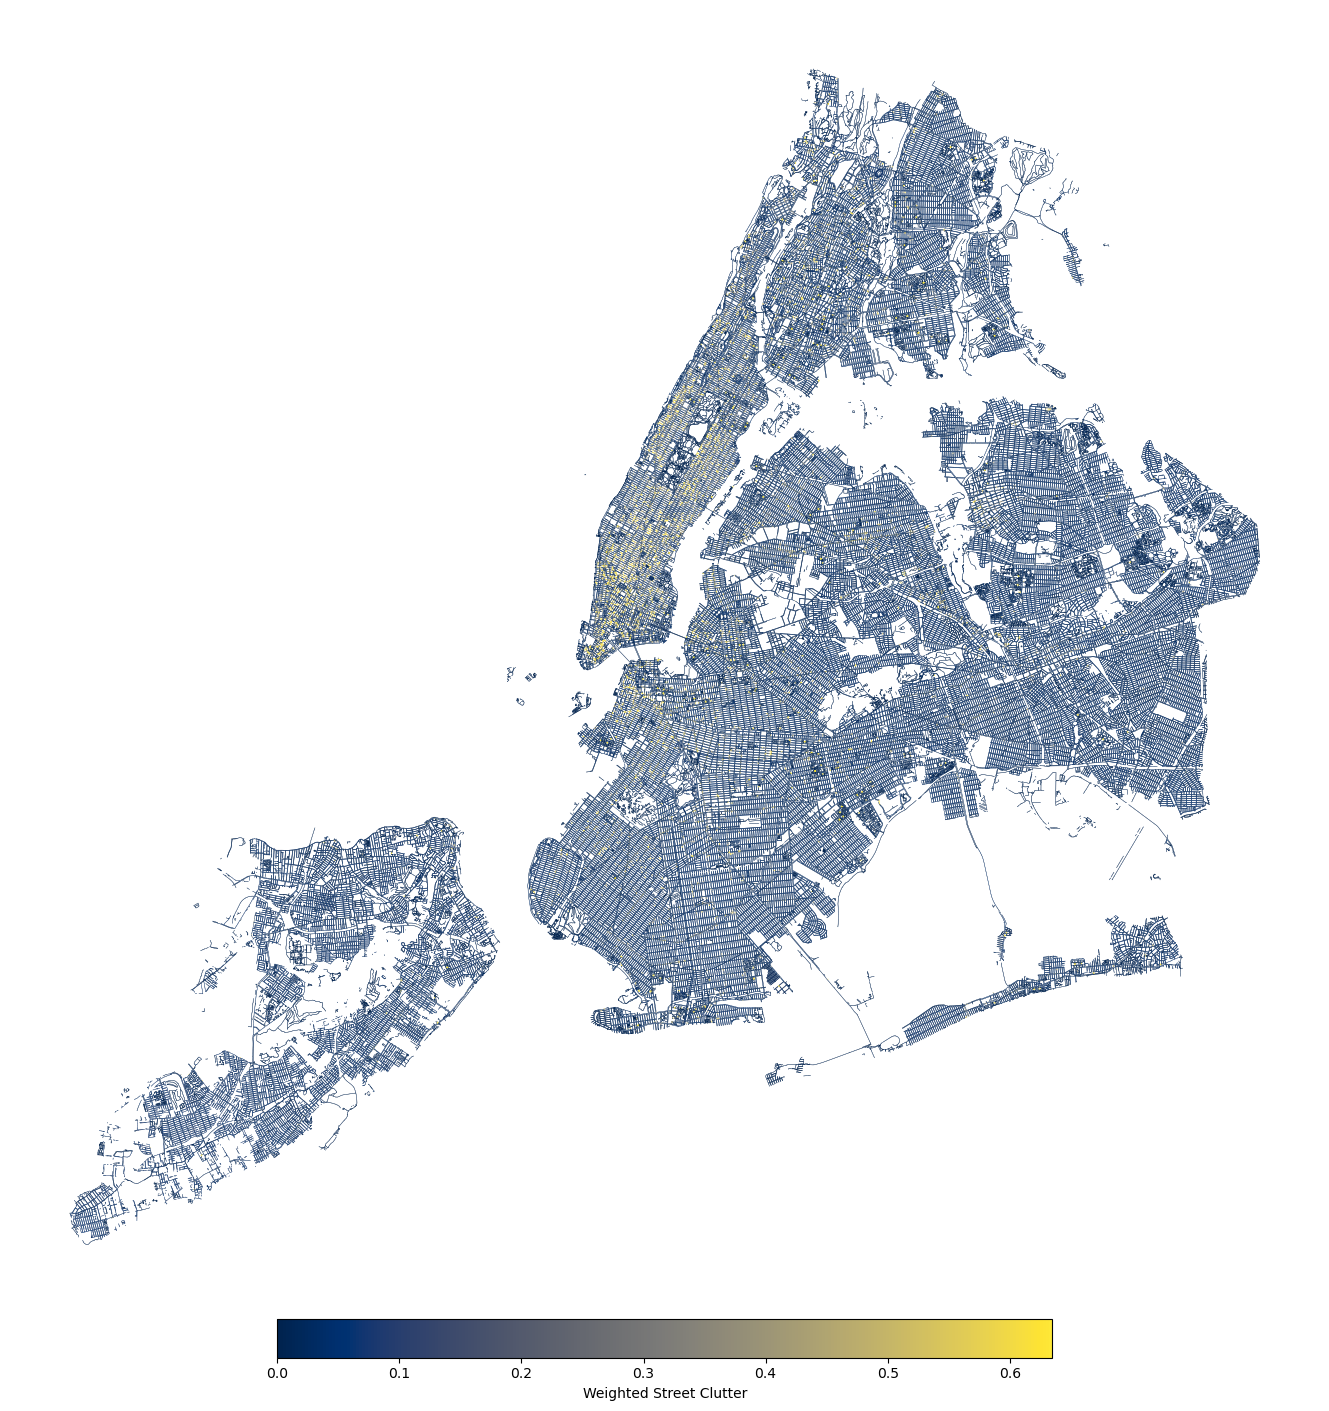

In [45]:
# map sidewalk and color by clutter 
fig, ax = plt.subplots(figsize=(20, 20))
nyc_sidewalks.plot(column='clutter', ax=ax, legend=True, cmap='cividis', markersize=0.25, legend_kwds={'label': "Weighted Street Clutter", 'orientation': 'horizontal', 'shrink': 0.5, 'pad': 0.01})
ax.set_axis_off()

plt.savefig("../figures/street_clutter.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [46]:
# write clutter to csv 
nyc_sidewalks.to_csv("../data/nyc_sidewalks_clutter.csv")